## About

Showing EEG, HR from ECG, HR from watch, accelerometer data for selected range

# First Seizure 

In [1]:
import sys
import os
sys.path.insert(1, os.path.join("./tools/"))
from helpers import *

In [2]:
# reload library
importlib.reload(sys.modules['helpers'])
from helpers import *

In [3]:
subject_name = "LB3_001_phaseII"
metadata = pd.DataFrame(json.load(open("./tools/subject_metadata_jp.json"))).T

In [4]:
real_start = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)
#time delta between real start and 1970-01-01 00:00
delta = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)-pd.to_datetime('1970-1-1').tz_localize(tz)
delta_time  = delta-pd.to_timedelta(delta.days, unit='days')

In [5]:

start_time_sec = 159834.140019 - 60 # showing starting 1 minute before the seizure
end_time_sec = 159834.140019 + 77.8599809999868 

#start time with ref to real date but correct time of day
sz_start_real= real_start + pd.to_timedelta(159834.140019, unit='s')
sz_end_real = real_start + pd.to_timedelta(159834.140019 + 77.8599809999868, unit='s')

#start time with ref to real date but correct time of day
seg_start_real = real_start + pd.to_timedelta(start_time_sec, unit='s')
seg_end_real = real_start + pd.to_timedelta(end_time_sec, unit='s')

#start time with ref to 1970 date but correct time of day
seg_start_1970= seg_start_real - pd.to_timedelta(delta.days, unit='days')
seg_end_1970 = seg_end_real- pd.to_timedelta(delta.days, unit='days')

In [6]:
#get data from portal
portal_name = metadata.loc[subject_name]['portal_ID']
ds = s.open_dataset(portal_name)

## Get EEG Data

In [7]:
data_pull_min=1
clip_duration_sec =  end_time_sec - start_time_sec
clip_duration_min = clip_duration_sec / 60

# how many data_pull_min minute data pulls are there?
n_iter = int(np.ceil(clip_duration_min / data_pull_min))

eeg_channels = ['LA01',
 'LA02',
 'LA03']

In [8]:
# eeg_all = pd.DataFrame()
# for i in tqdm(range(n_iter)):

#     start_usec = start_time_sec * 1e6 + i * (data_pull_min * 60 * 1e6)
#     if i == n_iter - 1:
#         end_usec = end_time_sec * 1e6
#     else:
#         end_usec = start_usec + (data_pull_min * 60 * 1e6)
#     data, fs = get_iEEG_data(username, pwd_bin_path, portal_name, start_usec, end_usec, select_electrodes=eeg_channels)

#     time = np.linspace(start_usec, end_usec, len(data), endpoint=False)
#     data.index = pd.to_datetime(time, unit='us')

#     eeg_all = eeg_all.append(data)
        

## Read saved data

In [9]:
iEEG_filename = 'HUP225_phaseII'
file = f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5" %()
eeg_all = pd.read_hdf(file, key='ieeg')

In [10]:
#shift to real time
eeg_all.index = eeg_all.index + pd.to_datetime('1970-1-1').tz_localize(tz) + delta

In [11]:
eeg_channels = eeg_all.columns[[16,17,18,25]]

## Shifting time and cut data

In [12]:
#shift to realtime
# eeg_all.index = eeg_all.index.tz_localize(tz) + delta

# #shift back to 1970
# eeg_all.index = eeg_all.index - pd.to_timedelta(delta.days, unit='days')


In [13]:
#fetch saved ecg hr, watch and acc data
data_root = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"
ecg_hr = fetch_h5(subject_name, data_root, "ecg_heart")
watch_hr = fetch_h5(subject_name, data_root, "watch_heart")
######### no watch accelerometer file for this patient ########
# watch_acc = fetch_h5(subject_name, data_root, "watch_acc")


# #shift ecg/wearables data to 1970 keeping time correct
# ecg_hr.index= ecg_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_hr.index= watch_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_acc.index= watch_acc.index - pd.to_timedelta(delta.days, unit='days')

# #cutting data to selected range
ecg_hr = ecg_hr[(ecg_hr.index>seg_start_real) & (ecg_hr.index< seg_end_real)]
watch_hr = watch_hr[(watch_hr.index>seg_start_real) & (watch_hr.index< seg_end_real)]
######### no watch accelerometer file for this patient ########
# watch_acc = watch_acc[(watch_acc.index>seg_start_real) & (watch_acc.index< seg_end_real)]

######### no watch accelerometer file for this patient ########
# Calc Acc magnitude
# watch_acc['mag'] = np.sqrt(np.sum(watch_acc**2, axis=1))

['ecg_heart.h5']
['watch_heart.h5']


## Plotting selected data

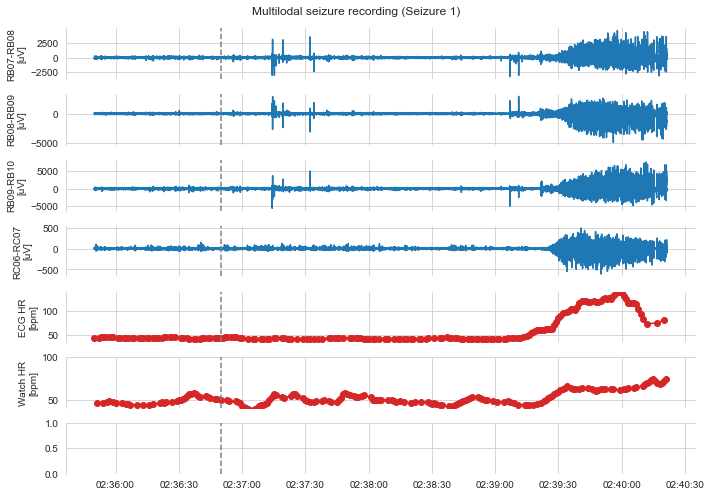

In [101]:
rw = len(eeg_channels)+3

fig, ax = plt.subplots(rw, 1, figsize=(10,rw), sharex=True)
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 10})

for i in range(len(eeg_channels)):
    axi = ax[i]
    axi.plot(eeg_all.index, eeg_all[eeg_channels[i]])
    axi.set_ylabel("%s\n[uV]" %(eeg_channels[i]))
    

axi = ax[len(eeg_channels)]
axi.plot(ecg_hr.index, ecg_hr['heartRate'],'o-', color='C3')
axi.set_ylabel("ECG HR\n[bpm]")
axi.set_ylim([35,140])

axi = ax[len(eeg_channels)+1]
axi.plot(watch_hr['heartRate'].dropna(),'o-', color='C3')
axi.set_ylabel("Watch HR\n[bpm]")
axi.set_ylim([40,100])

######### no watch accelerometer file for this patient ########
# axi = ax[len(eeg_channels)+2]
# axi.plot(watch_acc.index, watch_acc['mag'], color='C1')
# axi.set_ylabel("Acc Mag\n[G]")
# axi.set_xlabel("Time of day")

for a in ax:
    a.axvline(x=sz_start_real, ls='--', color='grey')


# xformatter = matplotlib.dates.DateFormatter('%H:%M')
# axi.xaxis.set_major_formatter(xformatter)

plt.suptitle("Multilodal seizure recording (Seizure 1)")
sns.despine(bottom=True)


plt.tight_layout()
# plt.savefig("./../../figures/%s_%s_%s.png" %(subject_name,start_time_sec,end_time_sec), dpi = 300, bbox_inches='tight')
plt.show()

# Second seizure

In [112]:
subject_name = "LB3_001_phaseII"
metadata = pd.DataFrame(json.load(open("./tools/subject_metadata_jp.json"))).T

In [113]:
real_start = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)
#time delta between real start and 1970-01-01 00:00
delta = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)-pd.to_datetime('1970-1-1').tz_localize(tz)
delta_time  = delta-pd.to_timedelta(delta.days, unit='days')

In [114]:

start_time_sec = 304819.92 - 60 # showing starting 1 minute before the seizure
end_time_sec = 304819.92 + 211.75 

#start time with ref to real date but correct time of day
sz_start_real= real_start + pd.to_timedelta(304819.92, unit='s')
sz_end_real = real_start + pd.to_timedelta(304819.92 + 211.75 , unit='s')

#start time with ref to real date but correct time of day
seg_start_real = real_start + pd.to_timedelta(start_time_sec, unit='s')
seg_end_real = real_start + pd.to_timedelta(end_time_sec, unit='s')

#start time with ref to 1970 date but correct time of day
seg_start_1970= seg_start_real - pd.to_timedelta(delta.days, unit='days')
seg_end_1970 = seg_end_real- pd.to_timedelta(delta.days, unit='days')

In [115]:
#get data from portal
portal_name = metadata.loc[subject_name]['portal_ID']
ds = s.open_dataset(portal_name)

## Get EEG Data 


In [116]:
data_pull_min=1
clip_duration_sec =  end_time_sec - start_time_sec
clip_duration_min = clip_duration_sec / 60

# how many data_pull_min minute data pulls are there?
n_iter = int(np.ceil(clip_duration_min / data_pull_min))

eeg_channels = ['LA01',
 'LA02',
 'LA03']

## Read saved data

In [117]:
iEEG_filename = 'HUP225_phaseII'
file = f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5" %()
eeg_all = pd.read_hdf(file, key='ieeg')

In [118]:
#shift to real time
eeg_all.index = eeg_all.index + pd.to_datetime('1970-1-1').tz_localize(tz) + delta

In [119]:
eeg_channels = eeg_all.columns[[16,17,18,25]]

## Shifting time & cut data

In [120]:
#fetch saved ecg hr, watch and acc data
data_root = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"
ecg_hr = fetch_h5(subject_name, data_root, "ecg_heart")
watch_hr = fetch_h5(subject_name, data_root, "watch_heart")
######### no watch accelerometer file for this patient ########
# watch_acc = fetch_h5(subject_name, data_root, "watch_acc")


# #shift ecg/wearables data to 1970 keeping time correct
# ecg_hr.index= ecg_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_hr.index= watch_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_acc.index= watch_acc.index - pd.to_timedelta(delta.days, unit='days')

# #cutting data to selected range
ecg_hr = ecg_hr[(ecg_hr.index>seg_start_real) & (ecg_hr.index< seg_end_real)]
watch_hr = watch_hr[(watch_hr.index>seg_start_real) & (watch_hr.index< seg_end_real)]
######### no watch accelerometer file for this patient ########
# watch_acc = watch_acc[(watch_acc.index>seg_start_real) & (watch_acc.index< seg_end_real)]

######### no watch accelerometer file for this patient ########
# Calc Acc magnitude
# watch_acc['mag'] = np.sqrt(np.sum(watch_acc**2, axis=1))

['ecg_heart.h5']
['watch_heart.h5']


## Plotting selected data

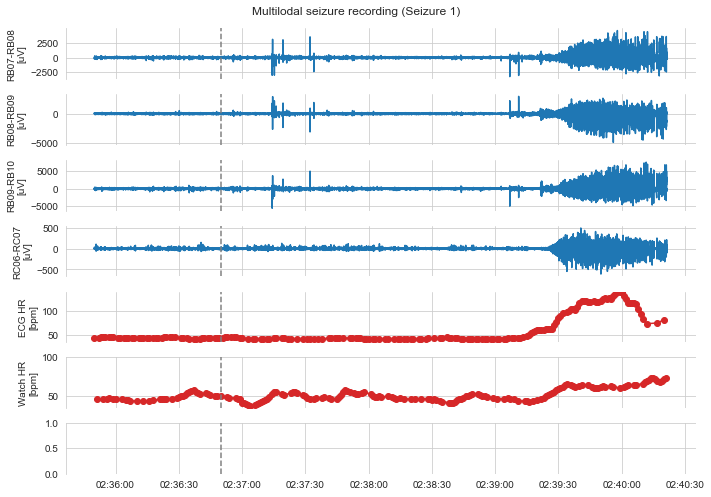

In [125]:
rw = len(eeg_channels)+3

fig, ax = plt.subplots(rw, 1, figsize=(10,rw), sharex=True)
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 10})

for i in range(len(eeg_channels)):
    axi = ax[i]
    axi.plot(eeg_all.index, eeg_all[eeg_channels[i]])
    axi.set_ylabel("%s\n[uV]" %(eeg_channels[i]))
    

axi = ax[len(eeg_channels)]
axi.plot(ecg_hr.index, ecg_hr['heartRate'],'o-', color='C3')
axi.set_ylabel("ECG HR\n[bpm]")
axi.set_ylim([35,140])

axi = ax[len(eeg_channels)+1]
axi.plot(watch_hr['heartRate'].dropna(),'o-', color='C3')
axi.set_ylabel("Watch HR\n[bpm]")
axi.set_ylim([35,100])

######### no watch accelerometer file for this patient ########
# axi = ax[len(eeg_channels)+2]
# axi.plot(watch_acc.index, watch_acc['mag'], color='C1')
# axi.set_ylabel("Acc Mag\n[G]")
# axi.set_xlabel("Time of day")

for a in ax:
    a.axvline(x=sz_start_real, ls='--', color='grey')


# xformatter = matplotlib.dates.DateFormatter('%H:%M')
# axi.xaxis.set_major_formatter(xformatter)

plt.suptitle("Multilodal seizure recording (Seizure 1)")
sns.despine(bottom=True)


plt.tight_layout()
# plt.savefig("./../../figures/%s_%s_%s.png" %(subject_name,start_time_sec,end_time_sec), dpi = 300, bbox_inches='tight')
plt.show()